# The floating escalator: Combining 1559 and the escalator

We've discussed EIP 1559 over the course of several notebooks. A competing proposal, dubbed "escalator", was [introduced by Dan Finlay](https://github.com/ethereum/EIPs/blob/master/EIPS/eip-2593.md), taking inspiration from a paper by [Agoric](https://agoric.com/papers/incentive-engineering-for-computational-resource-management/full-text/).

We take the current first-price auction paradigm as our benchmark. 1559 pushes the transaction fee market on an axis where a _reasonable_ fee is mandated to transact, where by "reasonable" we mean that the fee is dynamic and governed by supply and demand. Users become price-takers most of the time, with their only decision being whether to transact or not.

The escalator proposal is a somewhat orthogonal direction for the fee market. It retains some aspect of the first-price auction mechanism (users competing against each other) but allows users to "bump up" their bid following a linear formula. For instance, I initially bid 10 and specify that with each passing block, my bid should be increased by 5, until it reaches some maximum that I also defined. If I am included immediately, my gas price is 10. One block later, it is 15, etc.

The pattern of resubmitting transactions at a higher bid is known to most users of Ethereum. The escalator "automates" it in the sense that users do not need to manually resubmit, but set the parameters for the fee increase once and for all then send the transaction to the pool.

So on one axis we have a protocol-determined objective fee equalising supply and demand. On the other, we have control over bidding behaviour. The first is useful most of the time, in particular when demand is stationary. Yet the second may be desirable for these short periods where demand drastically changes and user behaviour reverts to strategic first-price auction-style bidding. Could we combine the two?

In this notebook, we investigate the **floating escalator**, a proposal to do so. We'll introduce its dynamics and study some user behaviours under this paradigm.

## Setting up

Find in the [README](../README.md) more instructions on how to run this notebook. We'll import objects from our library and introduce them in the following.

In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import (
    set_seed,
    constants,
)

from abm1559.txpool import TxPool

from abm1559.users import (
    UserFloatingEsc,
)

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

from abm1559.txs import (
    TxFloatingEsc,
)

import pandas as pd
import numpy as np
import seaborn as sns

## Floating escalator 101

Since the floating escalator relies on a combination of both 1559 and the escalator, we'll introduce each one in turn and look at their combination.

### Basefee in 1559

EIP 1559 targets a specific block size $c$. When blocks are too full, a price known as the _basefee_ increases. More people want in? Fine, we'll raise the prices then. Over time, the basefee fluctuates, with higher values reached when more users want to transact.

The basefee is governed by a simple equation

$$ b_{t+1} = b_t  \Big( 1 + \frac{g_t - c}{cd} \Big) $$

where $g_t$ is the amount of gas used by block $t$. Note that blocks here can use a maximum of $2c$ gas. When they do, and are full, the update rule above becomes $b_{t+1} = b_t \Big( 1 + \frac{1}{d} \Big)$.

$d$ is currently set at 8, which implies that the basefee after a full block increases by 12.5% (and basefee after an empty block decreases by 12.5%) [1].

### Escalator

In the escalator paradigm, a user submits their starting bid $\underline{p}$, the length of time this bid is valid for $\ell$ blocks (say between blocks $T$ and $T + \ell$) and their maximum bid $\overline{p}$. Over $\ell$ blocks, the true bid $\hat{p}_t$ at block $t$ follows a linear interpolation of $\underline{p}$ and $\overline{p}$, with

$$\hat{p} = \underline{b} + \frac{t - T}{\ell} (\overline{b} - \underline{b}) $$

In other words, the bid escalates slower or faster, depending on how much time it is valid for and how high the maximum bid is.

### Floating escalator

One issue with the escalator is that users need to set a larger number of parameters to specify (start bid, max bid, duration of the escalator). Meanwhile, 1559 gives us this nice gas price "oracle" that tells you the market conditions as you start transacting. Combining the two would be nice! Our escalator could "start" on the current 1559-predicated price, the basefee, and climb their bid from there!

What exactly climbs in the floating escalator? Remember that 1559 users specify a gas premium, or the maximum amount that a miner can receive from including the transaction. We've seen in times of transitions, e.g., a demand spike, users can win by becoming strategic and "overbidding" (compared to some premium exactly equal to the economic cost for a miner to include one extra transaction).

We call this hybrid "floating": we see the basefee as a kind of tide, rising and lowering with demand. The escalator starts at or near the tide. Meanwhile, the gas premium offered to the miners climbs _in excess_ of the basefee. For instance, assume Alice starts her escalator at the basefee equal to 5 Gwei and increases the bid by 1 Gwei each block. She also specifies that she never wants to pay more than 15 Gwei.

<AxesSubplot:xlabel='block_height'>

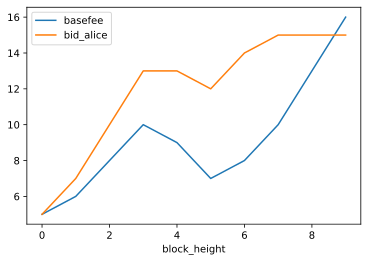

In [2]:
basefees = [5, 6, 8, 10, 9, 7, 8, 10, 13, 16]
bids_alice = [min(15, basefees[i] + i) for i in range(10)]

df = pd.DataFrame({
    "block_height": range(10),
    "basefee": basefees,
    "bid_alice": bids_alice,
})
df.plot("block_height", ["basefee", "bid_alice"])

Notice the distance between the basefee in blue and Alice's bids in orange increases over time, by 1 Gwei per block. At block 6, the basefee is 8 Gwei, so Alice's bid is 14 Gwei (8 Gwei from the basefee, 6 Gwei from her escalator). Then at block 7, the basefee increases to 10 Gwei. While Alice's bid ought to be 17 Gwei (10 Gwei from the basefee, 7 Gwei from her escalator), it is capped at 15 Gwei, which is the maximum amount Alice was willing to pay. We'll assume that after 10 blocks, Alice's transaction simply drops out.

Suppose a different user, Bob, starts at the same block as Alice, with an increase of 0.5 Gwei per block, and the same 15 Gwei limit.

<AxesSubplot:xlabel='block_height'>

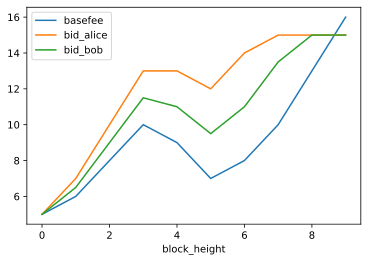

In [3]:
bids_bob = [min(15, basefees[i] + 0.5 * i) for i in range(10)]
df["bid_bob"] = bids_bob
df.plot("block_height", ["basefee", "bid_alice", "bid_bob"])

We see Bob's bids in green. Notice that they keep below Alice's bid. In a sense, Bob is more conservative than Alice is. Alice might be in a hurry to get her bid included, and doesn't mind "overpaying" if the increment she chose was too large. Bob, on the other hand, prefers to quietly escalate his bid. All things equal, Alice would be included before Bob is, since miners receive the difference between her bid and the basefee.

## User strategies in the floating escalator

In our model, users have both a _value_ for the transaction, $v$, and a cost for waiting, $c$. Getting included immediately nets you a payoff of $v$, minus the transaction fees expended. Getting included 2 blocks later, $v - 2c$, minus the transaction fees, etc.

Since $c$ represents the time preferences of the user (a higher $c$ means it is more costly for me to wait), we could decide the escalator slope based on $c$, the higher the $c$, the higher the slope and escalator increments.

We also need to decide for how long the escalator ramps up. Given increments of size $s$, after $t$ blocks, assuming a constant basefee $b$, my bid is $b + t \times s$. Meanwhile, if my transaction is included at $t$, my payoff is $v - t \times c - (b + t \times s)$. **We never want this payoff to become negative**: we would be worse off transacting than not! We can find out the number of blocks $t$ after which the previous expression becomes negative and use that as the duration of the escalator.

So how large should our increments be? We could set them to some fraction of the cost per unit, to respect the intuition that users who are more in a hurry would set higher increments. To simplify for now, we'll set them to be exactly the user's cost per unit.

In our simulations, the users' bids won't start on the basefee exactly. We'll define the `start_premium` parameter as one escalator increment: if this increment is $c$, the first bid the user places is $b + c$ [2].

We've written a "dummy" `UserFloatingEsc` class in the library that we extend here to specify the parameters discussed above.

In [4]:
class UserHurryEsc(UserFloatingEsc):
    
    def decide_parameters(self, params):
        basefee = params["basefee"]
        slope = self.cost_per_unit
        escalator_length = int(((self.value - basefee) / self.cost_per_unit - 1) / 2)
        max_fee = basefee + (escalator_length + 1) * self.cost_per_unit
        max_block = self.wakeup_block + escalator_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": basefee,
        }
        return tx_params

As in our previous notebooks, we'll write out the main simulation loop. Note that since the floating escalators have an expiry date (the max block after which they cannot be included), we add an extra step to clean up the transaction pool of expired transactions.

In [5]:
def simulate(demand_scenario, shares_scenario, TxPool = TxPool):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params, user_pool)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])
        
        ## NEW LINE
        # We remove invalid transactions: we assume floating escalator transactions
        # "expire" after their `max_block` parameter, and so can be removed.
        txpool.remove_invalid_txs(params)

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

We'll only simulate `UserHurryEsc` first, setting the average number of new users spawning between two blocks at 2,500. Our blocks can only accommodate 952 of them at most, so this will create congestion.

In [6]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

shares_scenario = [{
    UserHurryEsc: 1,
} for i in range(blocks)]

set_seed(42)

(df_hurry, user_pool_hurry, chain_hurry) = simulate(demand_scenario, shares_scenario)

Let's observe some results!

In [7]:
df_hurry

block    basefee  users  decided_txs  included_txs  blk_avg_gas_price  \
0       0   1.000000   2494         2257           952           1.768377   
1       1   1.124900   2563         2284           952           2.026010   
2       2   1.265400   2495         2213           952           2.407692   
3       3   1.423448   2577         2265           952           2.834767   
4       4   1.601237   2527         2193           952           3.219149   
..    ...        ...    ...          ...           ...                ...   
95     95  15.213655   2505          463           463          15.665931   
96     96  15.160978   2487          470           470          15.649491   
97     97  15.136341   2543          483           483          15.589225   
98     98  15.163397   2486          492           492          15.632873   
99     99  15.226326   2487          463           463          15.691863   

    blk_avg_tip  pool_length  
0      0.768377         1305  
1      0.901110         2625  
2      1.142292         3823  
3      1.411319         5035  
4      1.617912         6111  
..          ...          ...  
95     0.452276            0  
96     0.488514            0  
97     0.452884            0  
98     0.469475            0  
99     0.465537            0  

[100 rows x 8 columns]

We recognise dynamics that should be familiar to us now. While the same average number of `users` spawn each block, and blocks are full in the first few steps, by the end of the simulation a much smaller number of users decides to actually transact (`decided_txs`). A new phenomenon is the `pool_length` being exactly zero by the end. Since transactions expire, old unincluded transactions are removed, while new transactions in the pool are all included. The basefee has reached its stationary level after which most users are priced out. This is confirmed by the following plot.

<AxesSubplot:xlabel='block'>

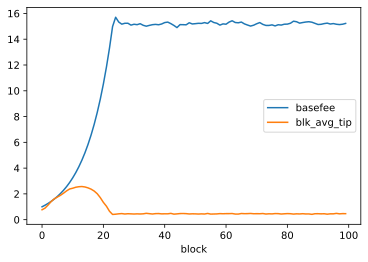

In [8]:
df_hurry.plot("block", ["basefee", "blk_avg_tip"])

Note the average tip in orange: in the first 20 blocks, when there is true competition from a shift in demand, many users want in given the low basefee amount, too many for all to be included. Those who wait in the pool see their bids escalate with increments equal to their cost per unit of waiting time. Miners of the blocks including highly escalated bids receive a much heftier tip, the difference between the user's bid and the current basefee. This comes to an end once basefee is stationary, after which priced out users do not even care to join the pool, escalating bids or not.

In [9]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_hurry_df = user_pool_hurry.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_hurry_df = chain_hurry.export()

# Join the two to associate transactions with their senders
user_txs_hurry_df = chain_hurry_df.join(user_pool_hurry_df.set_index("sender"), on="sender")

# We'll only look at the first 16 blocks
first_blocks = user_txs_hurry_df[user_txs_hurry_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")

Below, we are plotting the distribution of users included in each successive block. On the x-axis, we represent the value of the user $v_i$, while on the y-axis, we plot the cost per unit of time waiting $c_i$. Each point on one plot corresponds to one included transaction, with the point located at the (value, cost per unit) coordinates of the user. Additionally, we give a distinct colour to each wave of new users: users spawned before block 0 are blue, those spawned between blocks 0 and 1 are orange etc.

In [10]:
g = sns.FacetGrid(data=first_blocks, col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

The plot is quite busy, but we can observe the following:
 
- Focusing on the first plot (`block_height = 0`), we clearly see that only users with higher time preferences (high cost per unit) are included. This is not entirely surprising since they offer a premium equal to their cost for waiting, so miners who rank users according to that premium will prefer users with higher premiums -- and thus higher time preferences.
- On the second plot (`block_height = 1`), we see that most included users are new users in orange (who appeared just before block 1), while some users from the previous wave (in blue) are included too. These late users are users spawned before block 0 with relatively low cost per unit. Yet, having waited one block already, their escalating premium is higher than some of the new users spawned just before block 1, which justifies their inclusion.
- This goes on for the following steps, further waves of users appear, with the most hurried of these users included in the block as they appear while others wait for their turn, yielding their spots to users from previous waves who have waited longer.
- Another item to notice is the progressive shift to the right of the points. Remember that while all these transactions are included, blocks are getting full, and the basefee increases! This means **low-value users are progressively getting discouraged** from sending their transactions in. By block 15, only users with value greater than 10 Gwei per gas unit are included.
- It is not only progressively shifting to the right, it is also narrowing at the base. We even see users spawned in the first wave, before block 0, included in block 15. These users have a high value for the transaction, but a really low cost for waiting: they don't mind getting in much later as long as they get in eventually. The increments of their escalators are very small, but to stay in the race long enough, they must have a much higher value than fresher users with higher cost for waiting.

### Computing social welfare

The question then is: does the extra transaction expressivity afforded by the escalator improve the efficiency of the fee market? We first need to be clear what efficiency means in this context. A common measure in algorithmic game theory is the _social welfare_: the total payoff received by all users (transaction senders **and** miners) minus the costs they incur.

In our case, we have users with personal values $v_i$ and cost for waiting $c_i$. We run the fee market for blocks over time period $T$, when blocks $B_1, \dots, B_T$ are produced. Transaction senders pay transaction fees to miners, so this cost to the senders is merely extra payoff for the miners. In other words, the transaction fees do not participate to the social welfare calculation. The basefee does however, it is burnt, irretrievable and constitutes a cost to the system of miners and senders [3].

$$ \text{Social welfare}((b_t)_t, (w_i)_i) = \sum_{t \in T} \sum_{i \in B_t} g_i ( v_i - w_i \times c_i - b_t) $$

where $g_i$ is the gas used by sender $i$, $w_i$ is how long the user has waited and $b_t$ is the basefee at block $t$. Note that the social welfare (SW) is determined by the realisation of $(b_t)_t$ and $(w_i)_i$, which are not exogenous to the system (while $(g_i)_i, (v_i)_i$ and $(c_i)_i$ are).

Note that the sum above is only carried over _included_ users. Users who are not included pay nothing and receive no value either [4]. Note too that all things equal, SW is higher whenever users with higher costs for waiting get in quickly, or whenever users with higher values are included.

Let's investigate by computing the social welfare in the previous simulation. `user_txs_df` holds user data of all users who were included. Note that since all transactions in our simulation have the same gas used, we do not include this parameter in the social welfare.

In [11]:
user_txs_hurry_df["total_sw"] = user_txs_hurry_df.apply(
    lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit - row.basefee,
    axis = 1
)

We store in a new column `user_sw` the welfare achieved by each included user. We'll now sum them all up to obtain the social welfare.

In [12]:
sw_hurry = sum(user_txs_hurry_df["total_sw"])
sw_hurry

290918.01601975743

Hmmm, cool, I guess? That number alone is not very useful -- we'd better find something to compare it with. Why not try a different user strategy?

## A different behaviour

We've looked at a behaviour where the length of a user escalator depends on the value and the cost for waiting of that user. We can look at a different model, where we assume the length of the escalator is fixed and the slope depends on the value and cost.

Say all users set up their escalators to last $\ell = 10$ blocks. After waiting for 10 blocks, their payoff for inclusion is $\overline{b}_i = v_i - 10c_i$. We can use this value as the maximum fee they are ever willing to pay. If the basefee increases much in the meantime, their bid may reach the limit earlier, but at least users are guaranteed to never overpay and realise a negative payoff.

Once again, we'll want their initial bid to be the basefee plus one increment of their escalator. To determine the slope of the escalator, we simply look for the value $s_i$ such that

$$ b + s_i + \ell \times s_i = \overline{b}_i \Leftrightarrow s_i = \frac{\overline{b}_i - b}{\ell + 1} $$

This is implemented in the `UserFixedDuration` class below.

In [13]:
class UserFixedDuration(UserFloatingEsc):
    
    def decide_parameters(self, params):
        escalator_length = 10
        max_fee = self.value - escalator_length * self.cost_per_unit
        slope = (max_fee - params["basefee"]) / (escalator_length + 1)
        max_block = self.wakeup_block + escalator_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": params["basefee"],
        }
        return tx_params

We'll run the simulation again with these new users.

In [14]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

shares_scenario = [{
    UserFixedDuration: 1,
} for i in range(blocks)]

set_seed(42)

(df_fixed, user_pool_fixed, chain_fixed) = simulate(
    demand_scenario, shares_scenario,
)

Checking out the results...

In [15]:
df_fixed

block    basefee  users  decided_txs  included_txs  blk_avg_gas_price  \
0       0   1.000000   2449         1832           952           1.973142   
1       1   1.124900   2425         1807           952           2.175643   
2       2   1.265400   2486         1871           952           2.427858   
3       3   1.423448   2606         1988           952           2.789486   
4       4   1.601237   2565         1949           952           3.203989   
..    ...        ...    ...          ...           ...                ...   
95     95  11.052017   2435         1829           493          11.303352   
96     96  11.100784   2488         1848           482          11.353947   
97     97  11.117713   2458         1812           503          11.385621   
98     98  11.195954   2489         1843           464          11.457063   
99     99  11.160126   2598         1955           514          11.442840   

    blk_avg_tip  pool_length  
0      0.973142          779  
1      1.050743         1486  
2      1.162458         2208  
3      1.366038         2999  
4      1.602751         3680  
..          ...          ...  
95     0.251335            0  
96     0.253163            0  
97     0.267909            0  
98     0.261110            0  
99     0.282713            0  

[100 rows x 8 columns]

What stands out immediately is that many more users decide to join the pool, even in the last blocks. Previously, we always observed `decided_txs == included_txs` in blocks 95-99. Users decide to join if they expect a positive profit. With the strategy implemented, we never allow a user to ever realise a negative payoff.

However, when setting the escalator length to $\ell$, some users appear such that $v - c \ell < 0$. This value does not depend on the basefee, it is simply the value for the user of being included after waiting for $\ell$ blocks. Since we assume all users are willing to wait for at most $\ell$ blocks, these users where $v-c\ell$ will never make a positive profit, and so do not join at all.

This explains why `users != decided_txs`, but why don't we have `decided_txs == included_txs`? Simply put, it is never unprofitable to send the transaction in the first place. As long as there is no scenario where the user receives a negative payoff (which is the case as soon as $v - c\ell < 0$), then a user might as well send the transaction in.

However, the transaction pool checks for transaction validity, and removes all invalid transactions. We can define validity in two ways. Either we only call a transaction valid when its `max_block` parameter is higher than the current block, or we add the constraint that the basefee must be smaller than the gas price posted by the transaction.

Why is this important? There are two reasons why we might not want to drop transactions where basefee is higher than their posted gas price:

1. The basefee could always come back down! Keeping transactions around is memory-intensive, but a miner could realise a better profit from a transaction which could not be included as long as its gas price was smaller than the prevailing basefee. We explore [this situation in the notes here](https://github.com/ethereum/rig/blob/master/eip1559/notes-call3.md#important-client-strategies).
2. We could also decide that transactions with a gas price lower than the prevailing basefee could still be included, but the _miner_ must pay for the difference. The miner receives a tip from each transaction, equal to the difference between the transaction's gas price and the basefee for the block. When gas price is greater than basefee, the tip is positive, this is the regular case. When the opposite is true, the tip becomes negative, and the miner subsidises the transaction. One might want to have this option to allow miners inclusion of transactions they really want to include. To make sure everything is balanced, we still need to require that the sum of all tips be positive.

The second policy was indeed suggested in the original EIP, but has since fallen in disfavour, since this opened the door to exploitation.
The first reason why miners might want to keep transactions "submerged" by the current basefee still holds, and a good transaction ordering and memory policy for clients is yet to be found.

<AxesSubplot:xlabel='block'>

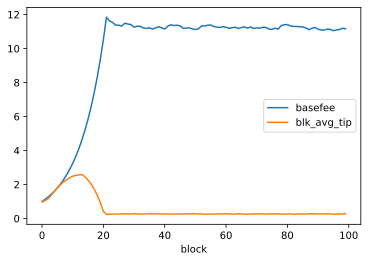

In [16]:
df_fixed.plot("block", ["basefee", "blk_avg_tip"])

In the chart above, we note that the basefee has settled at a level lower than it did in the previous simulation. This could be a clue that the user strategy we have defined, with fixed escalator lengths, achieves lower efficiency, as a high basefee indicates the presence of high-value users in the system (if there were none, the basefee would settle lower).

Let's repeat the steps we've done in the first simulation to understand our results.

In [17]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_fixed_df = user_pool_fixed.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_fixed_df = chain_fixed.export()

# Join the two to associate transactions with their senders
user_txs_fixed_df = chain_fixed_df.join(user_pool_fixed_df.set_index("sender"), on="sender")

# We'll only look at the first 16 blocks
first_blocks = user_txs_fixed_df[user_txs_fixed_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")

Once again, we plot the value and costs of included users across the first 16 blocks.

In [18]:
g = sns.FacetGrid(data=first_blocks, col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

There are some interesting regularities!

1. While we previously had early users included in late blocks (e.g., users from the first wave included in block 15), now users must either be included within 5 blocks or drop out. Not surprising since we set the escalator length to the fixed duration of five blocks, and adjusted the slope from there.
2. Once again, users are "stratified" in blocks. Low-valued users with high costs for waiting from earlier waves get in earlier than low-valued users with high costs for waiting from the current wave.
3. The oblique stratas are due to the condition we spelt out earlier, requiring that users with $v - c \ell < 0$ do not join the queue, since these would not be guaranteed a positive payoff in any scenario.
4. We observe again the shift towards the right, with low-valued users priced out as the basefee increases.

What of the social welfare now?

In [19]:
user_txs_fixed_df["total_sw"] = user_txs_fixed_df.apply(
    lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit - row.basefee,
    axis = 1
)
sw_fixed = sum(user_txs_fixed_df["total_sw"])
sw_fixed

427454.4752767864

In [20]:
sw_hurry

290918.01601975743

Seems that our alternative, "fixed", has a higher social welfare than the "hurry" model we've previously seen. What gives?

Although both social welfare measures are in the same "unit" (payoffs minus costs, so ethers), we are still not fairly comparing the two situations. In a sense, the "fixed length" escalator users are not at equilibrium: a high value user ought to bid higher to get in quickly, and not be discouraged by the possibility of not being included after the (arbitrary) escalator duration.

This is not to say that all users implementing the "hurried" strategy is an equilibrium either. Yet the basefee settles at a noticeably higher level, as if it was better able to match the existing demand to the supply.

The takeaway is that social welfare comparisons are not that informative when comparing two non-equilibrium profiles. A metric we could adopt instead is looking only at the profile of users who are included and compute the value they obtained -- their initial value minus waiting costs.

### Optimality

This metric is more helpful to compare the efficiency of the mechanism (and strategies) **relative to some optimum measure**. But defining the optimum is another issue. For instance, here is an unreasonable optimum: everyone is included! Since this is not a feasible scenario, we restrict our optimum to meaningful cases, where the constraints of the chain apply.

With each new wave of users, we have a new distribution of values and costs. We give a "greedy" optimum definition. At each wave, we include in a block as many _valid_ users as we can, with users who receive the highest payoff from inclusion (value minus waiting costs) first. The dynamics are the same as previously, except we replace our strategic miner optimising for their tips with a benevolent dictator whose sole objective is to maximise the immediate value of users in a block.

We subclass our `TxPool` object to implement this benevolent miner behaviour.

In [21]:
class GreedyTxPool(TxPool):
    def select_transactions(self, params, user_pool):
        
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(params)]
        valid_users = [user_pool.get_user(tx.sender) for tx in valid_txs]
        
        sorted_valid_demand = sorted(
            valid_users,
            key = lambda user: -user.current_value(params)
        )
        selected_users = [user.pub_key for user in sorted_valid_demand[0:max_tx_in_block]]
        selected_txs = [tx for tx in valid_txs if tx.sender in selected_users]

        return selected_txs

We'll also modify our users to have them transact always. Up until now, users estimated their expected payoff and decided to join on the condition that this payoff was nonnegative.

In [22]:
class AlwaysOnUser(UserFixedDuration):
    def create_transaction(self, params):
        # The tx_params don't really matter, since
        # greedy transaction pools disregard them to decide who is included
        tx_params = self.decide_parameters(params)
        
        tx = TxFloatingEsc(
            sender = self.pub_key,
            params = tx_params,
        )

        return tx

Rerun the simulation loop, using our new `GreedyTxPool` and `AlwaysOnUser`s.

In [23]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

shares_scenario = [{
    AlwaysOnUser: 1,
} for i in range(blocks)]

set_seed(42)

(df_greedy, user_pool_greedy, chain_greedy) = simulate(
    demand_scenario, shares_scenario,
    TxPool = GreedyTxPool,
)

In [24]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_greedy_df = user_pool_greedy.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_greedy_df = chain_greedy.export()

# Join the two to associate transactions with their senders
user_txs_greedy_df = chain_greedy_df.join(user_pool_greedy_df.set_index("sender"), on="sender")

In the next, we obtain the total (value minus waiting costs) of all included users.

In [25]:
def get_total_value(df):
    return sum(
        df.apply(
            lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit,
            axis = 1
        )
    )

pd.DataFrame({
    "simulation": ["greedy", "hurry", "fixed"],
    "total_value": [get_total_value(df) for df in [user_txs_greedy_df, user_txs_hurry_df, user_txs_fixed_df]]
})

simulation    total_value
0     greedy  960321.554725
1      hurry  955557.286343
2      fixed  931592.441688

Both total values of "hurry" and "fixed" simulations are below our greedy optimum [5]. They are not far, but "greedy" is  closer than fixed.

A non-greedy optimum measure would instead look at all the users spawned between all blocks during the simulation and find the assignment of _valid_ users to blocks that maximises total value. It may differ from the greedy optimum in cases where the total value is increased by not including a user at some stage to "make room" for higher value users in the next stage.

---

##### Footnotes

[1] This means basefee updates are not commutative! Raising basefee by 12.5% then decreasing it by 12.5% does not return it to its original level...

[2] This gives the inequality $v - tc - (b + (t+1)c) > 0 \Leftrightarrow v - b - c > 2ct \Leftrightarrow t < (v-b-c)/2c$ so $t^* = \lfloor (v-b-c)/2c \rfloor$.

[3] Although perhaps not a cost to the more general population of ETH holders, but we narrow our focus to the (senders, miners) system alone here.

[4] We could model their opportunity cost of locking up funds for the duration of their transaction, but we don't do it here.

[5] To be precise, we should execute several runs of the simulation to obtain different user samples.